### This notebook is in support of our paper "A Confident Deep Learning loss function for one-step Conformal Prediction approximation".

We show both the code used for results generation, and the specific results presented in the paper. For method descriptions and results interpretation, please see our paper here: https://arxiv.org/abs/2207.12377

#### Imports

In [1]:
from helpers import load_mnist, test_loss_func, generate_results_df, calc_error_rates, generate_distance_metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
np.random.seed(500)
import pandas as pd
import pickle
import seaborn as sns
sns.set(context='notebook', style="whitegrid", font='serif', font_scale=1, color_codes=True, rc=None)
from sklearn.model_selection import train_test_split
import time


import nonconformist
from nonconformist.acp import AggregatedCp, RandomSubSampler
from nonconformist.base import ClassifierAdapter
from nonconformist.icp import IcpClassifier
from nonconformist.nc import  ClassifierNc

import tensorflow as tf
from tensorflow.keras import layers, models

#### ```IS_LOAD_RESULTS = True``` shows the results presented in the paper. To generate new results, change value to ```False```

Note that depending on the available processing power, generating new results may take some time because of a gridsearch.

In [2]:
IS_LOAD_RESULTS = True

SAVE_DIR = "./pickles/MNIST intermediate results"
EPSILON = np.arange(0, 1.05, 0.05)

# MNIST dataset

We select classes 0 and 1 for binary classification.

In [3]:
X_train, y_train, X_test, y_test = load_mnist()

print("X_train:", X_train.shape, "y_train:", y_train.shape)

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

X_train: (60000, 28, 28, 1) y_train: (60000,)
[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


In [4]:
print("X_test:", X_test.shape, "y_test:", y_test.shape)

unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

X_test: (10000, 28, 28, 1) y_test: (10000,)
[[   0  980]
 [   1 1135]
 [   2 1032]
 [   3 1010]
 [   4  982]
 [   5  892]
 [   6  958]
 [   7 1028]
 [   8  974]
 [   9 1009]]


In [5]:
train_mask = np.logical_or(y_train==0, y_train==1)
test_mask = np.logical_or(y_test==0, y_test==1)

X_train = X_train[train_mask]
y_train = y_train[train_mask]
X_test = X_test[test_mask]
y_test = y_test[test_mask]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
b = np.bincount(y_train)
print({v:c for v, c in zip(np.unique(y_train), b[np.unique(y_train)]/len(y_train)*100)})

print("\nX_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (12665, 28, 28, 1) y_train: (12665,)
{0: 46.766679826292936, 1: 53.233320173707064}

X_test: (2115, 28, 28, 1) y_test: (2115,)


# Feedforward Neural Network

In [6]:
batch_size = 128
n_class = 2
input_shape = X_train.shape[1:]

In [7]:
class FFNN():
    def __init__(self, input_shape, n_class, optimizer='adam', a1='relu', a2='sigmoid', loss=None):
        
        self.input_shape, self.n_class, self.optimizer = input_shape, n_class, optimizer
        self.epochs, self.batch_size, self.validation_split, self.verbose, self.history = [None]*5
        self.a1, self.a2 = a1, a2
        
        if not loss:
            self.from_logits = not(self.a2=='softmax' or self.a2=='sigmoid')
            self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=self.from_logits)
        else:
            self.loss = loss
                
        self.model = models.Sequential()
        self.model.add(layers.Flatten(input_shape=self.input_shape))
        self.model.add(layers.Dense(24, activation=self.a1))
        self.model.add(layers.Dense(self.n_class, activation=self.a2))
        self.model.compile(optimizer=self.optimizer,
                  loss = self.loss,
                  metrics=['accuracy'])
        
        
    def fit(self, X_train, y_train, epochs=3, batch_size=32, validation_split=0.2, verbose=0, is_graph=False):
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.verbose = verbose
        
        self.history = self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size,
                                      validation_split=self.validation_split, verbose=self.verbose)
        return self
    
    
    def predict(self, X_test):
        return self.model.predict(X_test)
    
    
    def eval_graph(self, X_test=None, y_test=None):
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
        axs[0].plot(self.history.history['accuracy'], label="train")
        axs[0].plot(self.history.history['val_accuracy'], label="validation")
        axs[0].set(title='accuracy', ylabel='accuracy', xlabel='epoch')
        axs[0].legend(loc='lower right')

        axs[1].plot(self.history.history['loss'], label="train")
        axs[1].plot(self.history.history['val_loss'], label="validation")
        axs[1].set(title='loss', ylabel='loss', xlabel='epoch')
        axs[1].legend(loc='upper right')
        
        if not X_test is None:
            test_loss, test_acc = self.model.evaluate(X_test, y_test, verbose=self.verbose)
            axs[0].hlines(test_acc, 0, self.epochs-1, 'r', label="test")
            axs[0].legend(loc='lower right')
            axs[1].hlines(test_loss, 0, self.epochs-1, 'r', label="test")
            axs[1].legend(loc='upper right')
            return test_loss, test_acc

### Standard probailistic classification
Testing whether the model architecture is complex enough to model the relationship between sample input and expected label

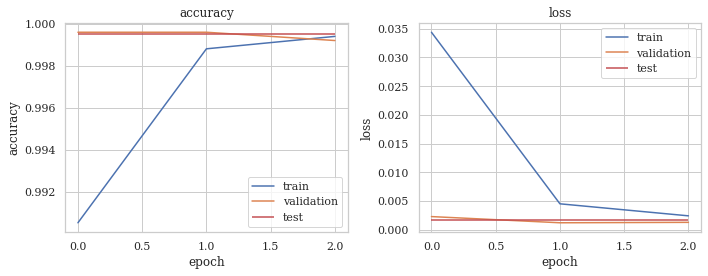

In [34]:
ffnn = FFNN(X_train.shape[1:], 2, a2='sigmoid') \
            .fit(X_train, y_train)

test_loss_ffnn, test_acc_ffnn = ffnn.eval_graph(X_test, y_test)

# Conformal loss function
Approximates standard two-step Conformal Prediction in one step. By measuring the distance of the DL model output distribution with that expected by CP, we may teach a neural network the direct relationship between data input and conformal p-values.

In [9]:
def conformal_loss(y_true, y_pred):
    # parameters for gridsearch
    global weight_l2
    global weight_huber
    global delta_huber
    global weight_var
    global weight_mean

    # label formatting
    y_onehot = tf.one_hot(tf.reshape(y_true, [-1]), depth=n_class)
    true_mask = tf.cast(y_onehot, tf.bool)
    false_mask = tf.math.logical_not(true_mask)
    y_pred_true = tf.reshape(tf.boolean_mask(y_pred, true_mask, axis=0), [-1, 1])
    y_pred_false = tf.reshape(tf.boolean_mask(y_pred, false_mask, axis=0), [-1, n_class-1])
    
    # evaluating false-class p-values (should be minimised to 0 for optimal predictive efficiency)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss_false = bce(tf.zeros_like(y_pred_false), y_pred_false)

    # evaluating true-class p-values (should be approximately uniformly distributed for
    # approximate validity, i.e. guaranteed maximum error rate)
    loss_l2 = tf.nn.l2_loss(y_pred_true/tf.reduce_sum(y_pred_true))
    loss_mean = tf.math.sqrt(tf.math.square(tf.reduce_mean(y_pred_true)-0.5))
    loss_var = tf.math.sqrt(tf.math.square(tf.math.reduce_variance(y_pred_true)-1/12))
    loss_huber = -tf.keras.losses.Huber(delta=delta_huber)(tf.fill(tf.shape(y_pred_true), 0.55), y_pred_true) 
    loss_true = weight_l2*loss_l2 + weight_huber*loss_huber + weight_mean*loss_mean + weight_var*loss_var 

    # total loss
    return loss_true + loss_false

In [10]:
if IS_LOAD_RESULTS:  # load results used in paper
    df_ffnn = pickle.load(open("./pickles/FFNN_MNIST_results_df-paper.pickle", 'rb'))

else:  # generate results, identify optimal loss parameters with a gridsearch
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
    print("Results saving to: {}".format(SAVE_DIR))

    for weight_l2 in [0, 1, 2, 5]:
        for weight_huber in [0.125, 0.25, 1, 2]:
            for delta_huber in [0.125,0.5, 1]:
                for weight_var in [0.5, 1, 2, 5]:
                    for weight_mean in [0.5, 1, 2, 5]:
                            model = FFNN(input_shape, n_class, loss=conformal_loss)
                            _, _ = test_loss_func(n_class, model, 'ffnn', X_train, y_train, X_test, y_test, batch_size, \
                                                  "FFNN conformal loss l2-{} hw-{} hd-{} v-{} m-{}".format(weight_l2, \
                                                  weight_huber, delta_huber, weight_var, weight_mean), SAVE_DIR)
    df_ffnn = generate_results_df('FFNN', SAVE_DIR, y_test)

The DataFrame columns are as follows:

- ```iter```: Identifier, the model was trained with the same loss function on the same data 10 times (0 <= ```iter``` <=10).
- ```loss```: Describes loss parameter weights, see the ```conformal_loss``` function above.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The tested model, see class ```FFNN``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [11]:
df_ffnn

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath
0,0,FFNN conformal loss l2-0 hw-0.125 hd-0.125 v-1...,8.668667e-28,0.840189,0.05,FFNN,4.000387,0.122279,0.121770,MNIST,./pickles/MNIST intermediate results - paper/0...
1,0,FFNN conformal loss l2-0 hw-0.125 hd-0.25 v-1 ...,3.548351e-49,0.972577,0.05,FFNN,3.561706,0.099534,0.162351,MNIST,./pickles/MNIST intermediate results - paper/0...
2,0,FFNN conformal loss l2-0 hw-0.125 hd-0.5 v-1 m...,1.511217e-41,0.806147,0.05,FFNN,3.255192,0.140597,0.149170,MNIST,./pickles/MNIST intermediate results - paper/0...
3,0,FFNN conformal loss l2-0 hw-0.25 hd-0.125 v-1 ...,3.243284e-59,0.963593,0.05,FFNN,2.776959,0.198767,0.178183,MNIST,./pickles/MNIST intermediate results - paper/0...
4,0,FFNN conformal loss l2-0 hw-0.25 hd-0.25 v-1 m...,3.559455e-124,0.978251,0.05,FFNN,3.666350,0.085141,0.257517,MNIST,./pickles/MNIST intermediate results - paper/0...
...,...,...,...,...,...,...,...,...,...,...,...
615,9,FFNN conformal loss l2-5 hw-0.5 hd-0.25 v-1 m-...,2.460442e-116,0.872813,0.05,FFNN,3.573674,0.284433,0.249345,MNIST,./pickles/MNIST intermediate results - paper/9...
616,9,FFNN conformal loss l2-5 hw-0.5 hd-0.5 v-1 m-1...,3.088114e-178,0.808983,0.05,FFNN,2.923566,0.302548,0.307657,MNIST,./pickles/MNIST intermediate results - paper/9...
617,9,FFNN conformal loss l2-5 hw-1 hd-0.125 v-1 m-1...,9.115417e-115,0.975414,0.05,FFNN,2.841424,0.114153,0.247676,MNIST,./pickles/MNIST intermediate results - paper/9...
618,9,FFNN conformal loss l2-5 hw-1 hd-0.25 v-1 m-1....,1.980677e-286,0.946099,0.05,FFNN,5.576026,0.144377,0.387527,MNIST,./pickles/MNIST intermediate results - paper/9...


## Identify optimal loss function parameters
Measured by checking the uniformtiy of the true-class p-values with the Kolmogorov-Smirnov test (ks_pvalue in the DataFrame) and the highest single-set rate (max_single).

In [12]:
top30 = df_ffnn.sort_values('ks_pvalue', ascending=False).head(30)
top30_medianKsPvalues = top30.groupby("loss")['ks_pvalue'].median()
loss_options = df_ffnn[df_ffnn.loss.isin(top30_medianKsPvalues.index)].groupby("loss")['max_single'].median().sort_values(ascending=False)

print(loss_options)

best_loss = str(loss_options.index[0])
print("\nBEST LOSS PARAMS: ", best_loss)

loss
FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 m-1.pickle       0.980378
FFNN conformal loss l2-5 hw-0.5 hd-0.125 v-1 m-1.pickle        0.980142
FFNN conformal loss l2-5 hw-0.25 hd-0.0625 v-5 m-1.pickle      0.979433
FFNN conformal loss l2-1 hw-0.125 hd-0.125 v-1 m-1.pickle      0.977069
FFNN conformal loss l2-10 hw-0.25 hd-0.25 v-1 m-1.pickle       0.974232
FFNN conformal loss l2-5 hw-0.25 hd-0.0625 v-1 m-1.pickle      0.972577
FFNN conformal loss l2-10 hw-0.25 hd-0.5 v-1 m-1.pickle        0.972104
FFNN conformal loss l2-1 hw-0.5 hd-0.125 v-1 m-1.pickle        0.966667
FFNN conformal loss l2-1 hw-0.125 hd-0.25 v-1 m-1.pickle       0.966430
FFNN conformal loss l2-0.5 hw-0.125 hd-0.125 v-1 m-1.pickle    0.965248
FFNN conformal loss l2-2 hw-0.25 hd-0.0625 v-1 m-1.pickle      0.964539
FFNN conformal loss l2-0.5 hw-0.125 hd-0.25 v-1 m-1.pickle     0.963121
FFNN conformal loss l2-0.5 hw-0.125 hd-0.5 v-1 m-1.pickle      0.962648
FFNN conformal loss l2-0 hw-0.125 hd-0.5 v-1 m-1.pickle    

In [13]:
df_ffnn_best = df_ffnn.query("loss==@best_loss")
df_ffnn_best

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath
53,0,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.093810e-30,0.979196,0.05,FFNN,3.718966,0.177764,0.128040,MNIST,./pickles/MNIST intermediate results - paper/0...
115,1,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.067491e-25,0.939007,0.05,FFNN,3.047652,0.163213,0.116373,MNIST,./pickles/MNIST intermediate results - paper/1...
177,2,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.349845e-35,0.985816,0.05,FFNN,3.843186,0.143845,0.136443,MNIST,./pickles/MNIST intermediate results - paper/2...
239,3,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243407e-20,0.964066,0.05,FFNN,4.341715,0.249414,0.104676,MNIST,./pickles/MNIST intermediate results - paper/3...
301,4,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,8.006426e-40,0.955556,0.05,FFNN,3.554470,0.170560,0.146023,MNIST,./pickles/MNIST intermediate results - paper/4...
363,5,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.611605e-32,0.980615,0.05,FFNN,2.960725,0.159360,0.131416,MNIST,./pickles/MNIST intermediate results - paper/5...
425,6,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,6.017028e-32,0.980142,0.05,FFNN,2.475206,0.116308,0.130669,MNIST,./pickles/MNIST intermediate results - paper/6...
487,7,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.000476e-32,0.986288,0.05,FFNN,4.015790,0.121749,0.132269,MNIST,./pickles/MNIST intermediate results - paper/7...
549,8,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,2.213406e-46,0.988652,0.05,FFNN,5.125406,0.093151,0.157653,MNIST,./pickles/MNIST intermediate results - paper/8...
611,9,FFNN conformal loss l2-5 hw-0.25 hd-0.125 v-1 ...,1.243964e-31,0.981087,0.05,FFNN,3.289945,0.143222,0.130016,MNIST,./pickles/MNIST intermediate results - paper/9...


# Aggregated Conformal Prediction (ACP)
Split the training set into a training proper and calibration set for the computationally efficiency inductive variant. To have the closest comparison, we use the same FFNN model and our conformal loss function as the underlying model.


**Read below if you would like to generate your own ACP results (i.e. ```IS_LOAD_RESULTS=False```), otherwise ignore.**

_The nonconformist package for ACP is not officially compatible with Python 3 or tensorflow models. Please make the following changes, filling in values for \<placeholders\>:_ (works as of 25/07/2022)
1. Open the file ~/anaconda3/envs/\<env-name\>/lib/python3.9/site-packages/nonconformist/acp.py. (file path might be different if you're using a different environment manager)
2. In lines 10 and 11, update the lines ```from sklearn.cross_validation import ...``` to ```from sklearn.model_selection import ...```
3. In line 78, comment out the entire ```def gen_samples(self, y, n_samples, problem_type): ...``` function, and replace with

```
def gen_samples(self, y, n_samples, problem_type):
    if problem_type == 'classification':
        splitter = StratifiedShuffleSplit(n_splits=n_samples,
                                       test_size=self.cal_portion)
        splits = splitter.split(y, y) # 'X' is ignored, but checked for length
    else:
        print("NOT compatible for regression")

    for train, cal in splits:
        yield train, cal
```
4. Add these two lines to the import section:
```
import tensorflow as tf
from tensorflow.keras.models import clone_model
```
5. After line ```predictor = clone(self.predictor)``` (196 in the AggregatedCp function ```def fit(self, x, y): ...```), include:
```
predictor.nc_function.model.model.model = clone_model(self.predictor.nc_function.model.model.model)
predictor.nc_function.model.model.model.compile(optimizer='adam',
      loss = predictor.nc_function.model.model.loss,
      metrics=['accuracy'])
```

In [14]:
X_train_prop, X_calib, y_train_prop, y_calib = train_test_split(X_train, y_train, test_size=1./3., random_state=42)

In [15]:
# placeholder parameters for the conformal loss function
global weight_l2
global weight_huber
global delta_huber
global weight_var
global weight_mean

weight_l2 = 1
weight_huber = 1
delta_huber = 1
weight_var = 1
weight_mean = 1

In [16]:
class FFNNAdapter(ClassifierAdapter):
    def __init__(self, model, fit_params=None):
        super(FFNNAdapter, self).__init__(model, fit_params)
        
        
    def fit(self, x, y):
        '''
            x is a numpy.array of shape (n_train, n_features)
            y is a numpy.array of shape (n_train)
            
            Here, do what is necessary to train the underlying model
            using the supplied training data
        '''
        self.model.fit(x, y, epochs=3, batch_size=128)
    
    def predict(self, x):
        '''
            Obtain predictions from the underlying model
            
            Make sure this function returns an output that is compatible with
            the nonconformity function used. For default nonconformity functions,
            output from this function should be class probability estimates in
            a numpy.array of shape (n_test, n_classes)
        '''
        return self.model.predict(x)

In [17]:
if IS_LOAD_RESULTS:  # load results used in paper
    df_acp = pickle.load(open("./pickles/ACP_MNIST_results_df-paper.pickle", 'rb'))
    
else:  # generate new results (see instructions under 'Aggregated Conformal Prediction' header)
    for i in range(1, 11):
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)
        print("Results saving to: {}".format(SAVE_DIR))

        filename = "{}/{} - ACP".format(SAVE_DIR, i)
        acp_fnn = AggregatedCp(IcpClassifier(ClassifierNc(FFNNAdapter(FFNN(input_shape, n_class, a2='sigmoid', loss=conformal_loss)))), RandomSubSampler(), n_models=i)

        acp_time_train_start_fnn = time.time()
        acp_fnn.fit(X_train, y_train)
        acp_time_train_end_fnn = time.time()
        acp_pvalues_train_fnn = acp_fnn.predict(X_test)

        acp_time_test_start_fnn = time.time()
        acp_pvalues_test_fnn = acp_fnn.predict(X_test)
        acp_time_test_end_fnn = time.time()

        iter_results = {'durations': {'train': acp_time_train_end_fnn-acp_time_train_start_fnn,
                                      'test': acp_time_test_end_fnn-acp_time_test_start_fnn},
                            'pvalues':   {'train': acp_pvalues_train_fnn, 'test': acp_pvalues_test_fnn},
                            'losses': None}
        pickle.dump(iter_results, open(filename+".pickle", 'wb'))
        print("ACP with n={} saved to {}".format(i, filename))

    df_acp = generate_results_df('ACP', SAVE_DIR, y_test)
    
df_acp = df_acp.sort_values('iter', ascending=True)

The DataFrame columns are as follows:

- ```iter```: Number of ensemble models for ACP (0 <= ```iter``` <=10).
- ```loss```: Not given for ACP.
- ```ks_pvalue```: P-value of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```ks_stat```: Statistic of a Kolmogorov-Smirnov test for uniformity on the true-class approximated p-value model output.
- ```max_single```: The maximum single-set rate across all signifiance levels (optimal Conformal Prediction set size).
- ```max_single_e```: Corresponding epsilon at which the maximum single-set rate was achieved.
- ```model```: The underlying model for ACP, see class ```FFNNAdapter``` above.
- ```time_train```: Time taken for training.
- ```time_test```: Time taken for testing.
- ```data```: The dataset on which the model was trained and tested.

In [18]:
df_acp

,iter,loss,ks_pvalue,max_single,max_single_e,model,time_train,time_test,ks_stat,data,filepath
0,1,ACP.pickle,9.551181e-02,0.963121,0.05,FFNN,3.461906,0.627876,0.026736,MNIST,./pickles/MNIST intermediate results - paper/1...
2,2,ACP.pickle,1.636114e-06,0.962175,0.05,FFNN,8.995863,2.569911,0.057467,MNIST,./pickles/MNIST intermediate results - paper/2...
3,3,ACP.pickle,8.705165e-54,0.975887,0.05,FFNN,11.008960,1.894581,0.169810,MNIST,./pickles/MNIST intermediate results - paper/3...
4,4,ACP.pickle,4.580035e-56,0.975414,0.05,FFNN,13.575046,3.093303,0.173376,MNIST,./pickles/MNIST intermediate results - paper/4...
5,5,ACP.pickle,7.485144e-58,0.977305,0.05,FFNN,18.895204,3.314333,0.176119,MNIST,./pickles/MNIST intermediate results - paper/5...
6,6,ACP.pickle,1.299872e-71,0.980142,0.05,FFNN,15.065170,2.970286,0.195931,MNIST,./pickles/MNIST intermediate results - paper/6...
7,7,ACP.pickle,1.833503e-141,0.981087,0.05,FFNN,17.840156,4.114154,0.274626,MNIST,./pickles/MNIST intermediate results - paper/7...
8,8,ACP.pickle,3.045701e-139,0.979669,0.05,FFNN,23.805764,4.532740,0.272493,MNIST,./pickles/MNIST intermediate results - paper/8...
9,9,ACP.pickle,2.361949e-91,0.979196,0.05,FFNN,26.825593,4.405970,0.221178,MNIST,./pickles/MNIST intermediate results - paper/9...
1,10,ACP.pickle,5.428672e-39,0.974468,0.05,FFNN,26.963113,5.744297,0.144481,MNIST,./pickles/MNIST intermediate results - paper/1...


# Empirical results
We compare our proposed conformal loss function to the ensemble Conformal Prediction variant, Aggregated Conformal Prediction (ACP). The results confirm that our one-step CP approximation is signifianctly less computationally expensive, while being competitive with ACP in terms of approximate validity and predictive efficiency.

In [19]:
colors = sns.color_palette()

### Calibration

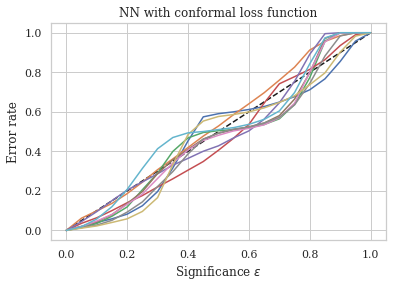

In [20]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
dists = list()

for i in df_ffnn_best.index:
    filepath = df_ffnn_best.loc[i].filepath
    
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)
    dists.append(np.linalg.norm(EPSILON-err))

    sns.lineplot(x=EPSILON, y=err)
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
plt.title("NN with conformal loss function")

plt.show()

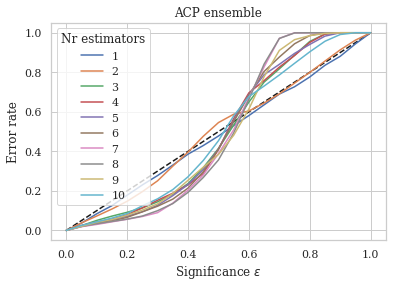

In [21]:
fig = plt.figure()

plt.plot([0, 1], [0, 1], 'k--')

for i in range(1, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    err, _ = calc_error_rates(results['pvalues']['test'], y_test, eps=EPSILON)

    sns.lineplot(x=EPSILON, y=err, label=str(i))
    
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Error rate")
plt.title("ACP ensemble")
plt.legend(title="Nr estimators")

plt.show()

### Approximate validity

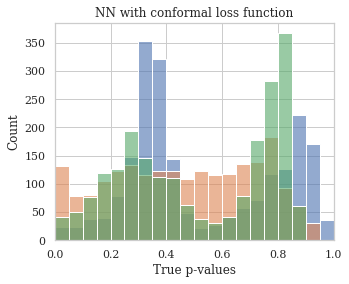

In [22]:
np.random.seed(42)
j = 0
fig = plt.figure(figsize=(5, 4))

for i in np.random.choice(range(0, 10), 3, replace=False):
    filepath = df_ffnn_best.query("iter==@i").filepath.values[0]
    results = pickle.load(open(filepath, 'rb'))
    true_p_values = results['pvalues']['test'][np.arange(y_test.shape[0]), y_test]
    
    sns.histplot(true_p_values, binrange=(0, 1), bins=20, color=colors[j], alpha=0.6)
    j = j+1
    
plt.xlabel("True p-values")
plt.xlim(0, 1)
plt.title("NN with conformal loss function")

plt.show()

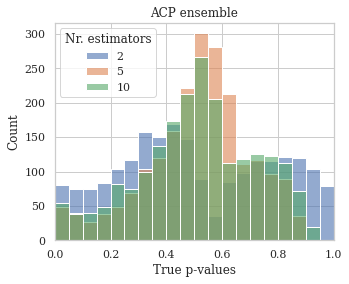

In [23]:
fig = plt.figure(figsize=(5, 4))
j = 0

for i in [2, 5, 10]:
    filepath = df_acp.query("iter==@i").filepath.values[0]    
    results = pickle.load(open(filepath, 'rb'))
    true_p_values = results['pvalues']['test'][np.arange(y_test.shape[0]), y_test]
    
    sns.histplot(true_p_values, label=str(i), binrange=(0, 1), bins=20, color=colors[j], alpha=0.6)
    j = j+1
    
plt.xlabel("True p-values")
plt.xlim(0, 1)
plt.legend(title="Nr. estimators")
plt.title("ACP ensemble")

plt.show()

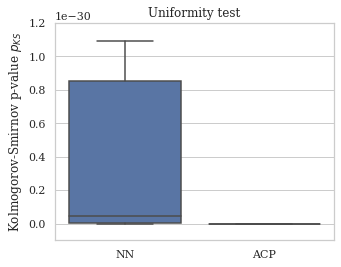

In [24]:
fig = plt.figure(figsize=(5, 4))

sns.boxplot(y=np.hstack((df_ffnn_best.ks_pvalue.values, df_acp.ks_pvalue.values)), x=(['NN']*10)+['ACP']*10)

plt.ylim(-1e-31, 1.2e-30)
plt.ylabel("Kolmogorov-Smirnov p-value $p_{KS}$")
plt.title("Uniformity test")

plt.show()

### False p-value distribution

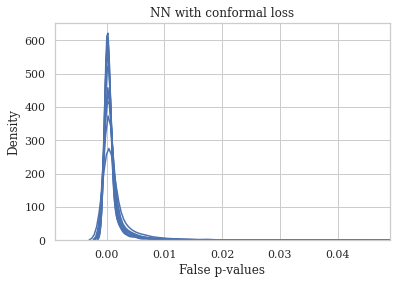

In [25]:
fig = plt.figure()

for i in df_ffnn_best.index:
    filepath = df_ffnn_best.loc[i].filepath
    results = pickle.load(open(filepath, 'rb'))

    true_indx = np.full_like(results['pvalues']['test'], False, dtype=bool)
    true_indx[np.arange(y_test.shape[0]), y_test] = True
    false_p_hat = results['pvalues']['test'][np.invert(true_indx)]
    
    sns.kdeplot(false_p_hat, color='b')
    
plt.xlabel("False p-values")
plt.xlim(-0.009, 0.049)
plt.title("NN with conformal loss")

plt.show()

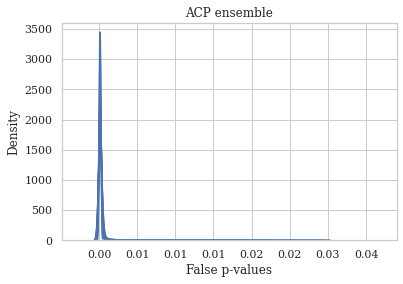

In [26]:
fig = plt.figure()

for i in range(1, 11):
    filepath = df_acp.query("iter==@i").filepath.values[0]    
    results = pickle.load(open(filepath, 'rb'))

    true_indx = np.full_like(results['pvalues']['test'], False, dtype=bool)
    true_indx[np.arange(y_test.shape[0]), y_test] = True
    false_p_hat = results['pvalues']['test'][np.invert(true_indx)]
    
    sns.kdeplot(false_p_hat, color='b')    
plt.xlabel("False p-values")
ax = plt.gca()
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlim(-0.0049, 0.039)
plt.ylim(0, 3600)
plt.title("ACP ensemble")

plt.show()

### Calibration vs predictive efficiency trade-off

In [27]:
eval_df_nn, dists_nn, avgs_nn = generate_distance_metrics(df_ffnn_best, y_test)
eval_df_acp, dists_acp, avgs_acp = generate_distance_metrics(df_acp, y_test)

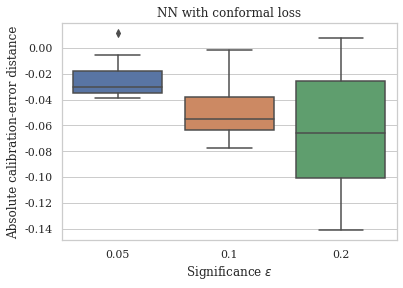

In [28]:
fig = plt.figure()
temp_df = pd.DataFrame(columns=['dist', 'eps'])
temp_df.dist = dists_nn.flatten('F')
temp_df.eps = np.repeat([0.05, 0.1, 0.2], 10)

sns.boxplot(y='dist', x='eps', data=temp_df)
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Absolute calibration-error distance")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title("NN with conformal loss")

plt.show()

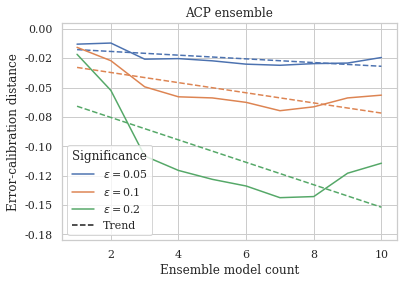

In [29]:
fig = plt.figure()
j = 0
for i, e in enumerate([1, 2, 4]):
    sns.lineplot(x=range(1, 11), y=dists_acp[:, i], label="$\epsilon=$"+str(EPSILON[e]))

    z = np.polyfit(range(1, 11), dists_acp[:, i], 1)
    p = np.poly1d(z)
    plt.plot(range(1, 11), p(range(1, 11)), linestyle="--", color=colors[j])
    j = j+1
    
plt.vlines(4, 2, 4, linestyle='--', color='k', label="Trend")

plt.legend(title="Significance")
plt.xlabel("Ensemble model count")
plt.ylabel("Error-calibration distance")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(-0.18, 0.005)
plt.title("ACP ensemble")

plt.show()

### Average prediction set size

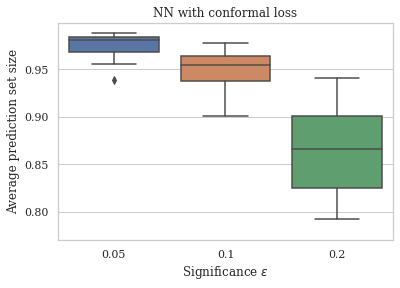

In [30]:
fig = plt.figure()
temp_df = pd.DataFrame(columns=['avg', 'eps'])
temp_df.avg = avgs_nn.flatten('F')
temp_df.eps = np.repeat([0.05, 0.1, 0.2], 10)

sns.boxplot(y='avg', x='eps', data=temp_df)
plt.xlabel("Significance $\epsilon$")
plt.ylabel("Average prediction set size")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(0.77, 0.999)
plt.title("NN with conformal loss")

plt.show()

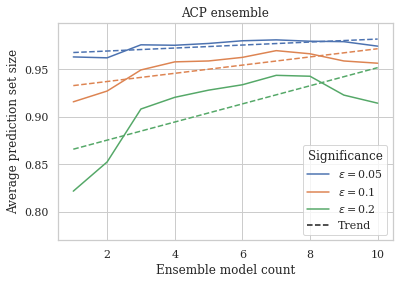

In [31]:
fig = plt.figure()
j = 0
for i, e in enumerate([1, 2, 4]):
    sns.lineplot(x=range(1, 11), y=avgs_acp[:, i], label="$\epsilon=$"+str(EPSILON[e]))

    z = np.polyfit(range(1, 11), avgs_acp[:, i], 1)
    p = np.poly1d(z)
    plt.plot(range(1, 11), p(range(1, 11)), linestyle="--", color=colors[j])
    j = j+1
    
plt.vlines(2, 2, 4, linestyle='--', color='k', label="Trend")

plt.legend(title="Significance")
plt.xlabel("Ensemble model count")
plt.ylabel("Average prediction set size")
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.ylim(0.77, 0.999)
plt.title("ACP ensemble")

plt.show()

### Training time

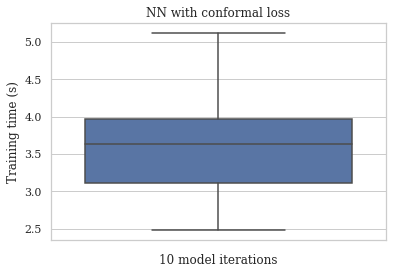

In [32]:
fig = plt.figure()
sns.boxplot(y='time_train', data=df_ffnn_best)

plt.ylabel("Training time (s)")
plt.xlabel("10 model iterations")
plt.title("NN with conformal loss")

plt.show()

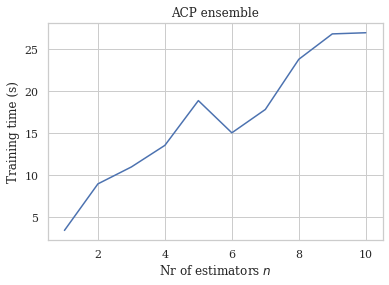

In [33]:
fig = plt.figure()
sns.lineplot(x="iter", y="time_train", data=df_acp)
plt.xlim(0.5, 10.5)
plt.ylabel("Training time (s)")
plt.xlabel("Nr of estimators $n$")
plt.title("ACP ensemble")

plt.show()